# Experimento 2 - Variação entre Perfis

**Objetivo**: Verificar se a mesma pergunta gera respostas significativamente diferentes quando o perfil do usuário varia.

**Metodologia**:
* Escolher 3 perfis de usuário,
* Escolher 10 perguntas,
* Para cada pergunda, gerar uma resposta para cada perfil.
* Aplicar métricas de similaridade semântica (BERTScore, Similaridade Cosseno, etc) entre as respostas para uma mesma pergunta.

In [132]:
import json
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import edit_distance
from bert_score import score as bert_score

In [133]:
# Carregar arquivo JSON com respostas dos três perfis
with open("/Users/gustavolgcr/doutorado/implementacoes/experiments/src/data/questions_and_answers_experiment_2_v2.json", "r", encoding="utf-8") as f:
    dados = json.load(f)

df = pd.DataFrame(dados)
df.head()

,pergunta,resposta_torcedor_do_time,resposta_tecnico_do_time,resposta_narrador_de_jogo_de_futebol
0,Qual foi a velocidade média de Bruno Pacheco n...,"Olha, meu amigo, sobre o Bruno Pacheco naquele...",A velocidade média registrada por Bruno Pachec...,"No jogo contra o Ceará no dia 1 de abril, Brun..."
1,Qual jogador apresentou a maior quantidade de ...,"No jogo contra o Ceará no começo de abril, que...",O jogador que apresentou a maior frequência de...,No emocionante clássico contra o Ceará no dia ...
2,Qual foi o tempo total que Bruno Pacheco passo...,"Olha, meu amigo, o Bruno Pacheco realmente deu...",Bruno Pacheco permaneceu em atividade de sprin...,"Naqueles momentos intensos, nosso destemido Br..."
3,Qual jogador teve o maior tempo parado ao long...,"Fala, torcedor! Então, sobre o clássico contra...",O atleta que teve o maior tempo em condição es...,Durante o jogo contra o Ceará no dia 1º de abr...
4,Qual foi a média de aceleração de todos os jog...,"Fala, parceiro! Olha, o jogo contra o Ceará no...",A média geral de aceleração dos jogadores da e...,"No dia 1º de abril de 2023, nossa equipe enfre..."


# Similaridade Textual

## Comparação das Respostas para a Mesma Pergunta


<span style="color:red">*Trocar o perfil base para uma resposta sem personalização*.</span>


In [49]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import textdistance
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

| Métrica           | Faixa de valores       | 0 significa...                                 | 1 significa...                          | Interpretação prática                                                                 |
|-------------------|------------------------|------------------------------------------------|-----------------------------------------|----------------------------------------------------------------------------------------|
| **Jaccard**        | 0 → 1                  | Nenhuma palavra em comum                       | Conjunto de palavras idêntico           | Leva em conta apenas **presença/ausência** de termos                                   |
| **Cosine TF-IDF**  | 0 → 1                  | Vetores de termos completamente diferentes     | Vetores idênticos                       | Considera **frequência** e distribuição de palavras                                    |
| **BLEU**           | 0 → 1                  | Nenhuma n-grama compartilhada                  | Todas n-gramas idênticas                | Penaliza diferenças de ordem e **tamanho do texto**                                    |
| **ROUGE-L**        | 0 → 1                  | Nenhuma subsequência comum                     | Sequências idênticas                    | Avalia **ordem relativa** das palavras                                                 |
| **Edit Distance**  | 0 → ∞ (ou normalizado: 0 → 1) | Textos idênticos (distância zero)       | Textos muito diferentes (grande distância) | Mede o número de **operações de edição** (inserções, remoções, substituições) |

In [50]:
def jaccard_similarity(a, b):
    set_a = set(a.lower().split())
    set_b = set(b.lower().split())
    return len(set_a & set_b) / len(set_a | set_b)

def cosine_tfidf_similarity(a, b):
    vect = TfidfVectorizer().fit([a, b])
    tfidf = vect.transform([a, b])
    return cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]

def bleu_score(a, b):
    smoothie = SmoothingFunction().method4
    return sentence_bleu([a.split()], b.split(), smoothing_function=smoothie)

def rouge_l_score(a, b):
    rouge = Rouge()
    scores = rouge.get_scores(a, b, avg=True)
    return scores['rouge-l']['f']

def edit_distance(a, b):
    return textdistance.levenshtein.normalized_similarity(a, b)

In [54]:
perfis = [col for col in df.columns if col not in ["pergunta", "resposta_leigo"]]
referencia = "resposta_leigo"
resultados = []

for _, row in df.iterrows():
    pergunta = row["pergunta"]
    resposta_ref = row[referencia]
    
    for perfil in perfis:
        resposta = row[perfil]
        resultados.append({
            "pergunta": pergunta,
            "perfil": perfil,
            "referencia": referencia,
            "jaccard": jaccard_similarity(resposta, resposta_ref),
            "cosine_tfidf": cosine_tfidf_similarity(resposta, resposta_ref),
            "bleu": bleu_score(resposta, resposta_ref),
            "rouge_l": rouge_l_score(resposta, resposta_ref),
            "edit_distance": edit_distance(resposta, resposta_ref)
        })

df_resultados = pd.DataFrame(resultados)

In [57]:
df_resultados.head(11)

,pergunta,perfil,referencia,jaccard,cosine_tfidf,bleu,rouge_l,edit_distance
0,Quais jogadores mais se destacaram no jogo con...,resposta_torcedor_infantil,resposta_leigo,0.157534,0.248155,0.046014,0.238636,0.296600
1,Quais jogadores mais se destacaram no jogo con...,resposta_influenciador_digital,resposta_leigo,0.187500,0.334742,0.050644,0.300469,0.278020
2,Quais jogadores mais se destacaram no jogo con...,resposta_perfil_comico,resposta_leigo,0.166667,0.330057,0.055038,0.236453,0.280957
3,Quais jogadores mais se destacaram no jogo con...,resposta_torcedor_do_time,resposta_leigo,0.200000,0.255310,0.046238,0.315789,0.309847
4,Quais jogadores mais se destacaram no jogo con...,resposta_reporter_esportivo,resposta_leigo,0.168539,0.216596,0.016890,0.285714,0.247360
5,Quais jogadores mais se destacaram no jogo con...,resposta_professor_de_educacao_fisica,resposta_leigo,0.192513,0.430216,0.056102,0.307018,0.278958
6,Quais jogadores mais se destacaram no jogo con...,resposta_torcedor_idoso,resposta_leigo,0.166667,0.352533,0.112948,0.242424,0.265668
7,Quais jogadores mais se destacaram no jogo con...,resposta_tecnico_do_time,resposta_leigo,0.159341,0.395367,0.032583,0.263158,0.271378
8,Quais jogadores mais se destacaram no jogo con...,resposta_olheiro_(scout),resposta_leigo,0.153005,0.351727,0.025793,0.245455,0.260295
9,Quais jogadores mais se destacaram no jogo con...,resposta_preparador_fisico,resposta_leigo,0.194030,0.251574,0.037160,0.292683,0.289003


In [60]:
# Criar mapeamento para perguntas como P1, P2, ...
perguntas_unicas = df_resultados["pergunta"].unique()
mapa_perguntas = {pergunta: f"P{i+1}" for i, pergunta in enumerate(perguntas_unicas)}

# Aplicar mapeamento no dataframe
df_resultados["pergunta_simplificada"] = df_resultados["pergunta"].map(mapa_perguntas)

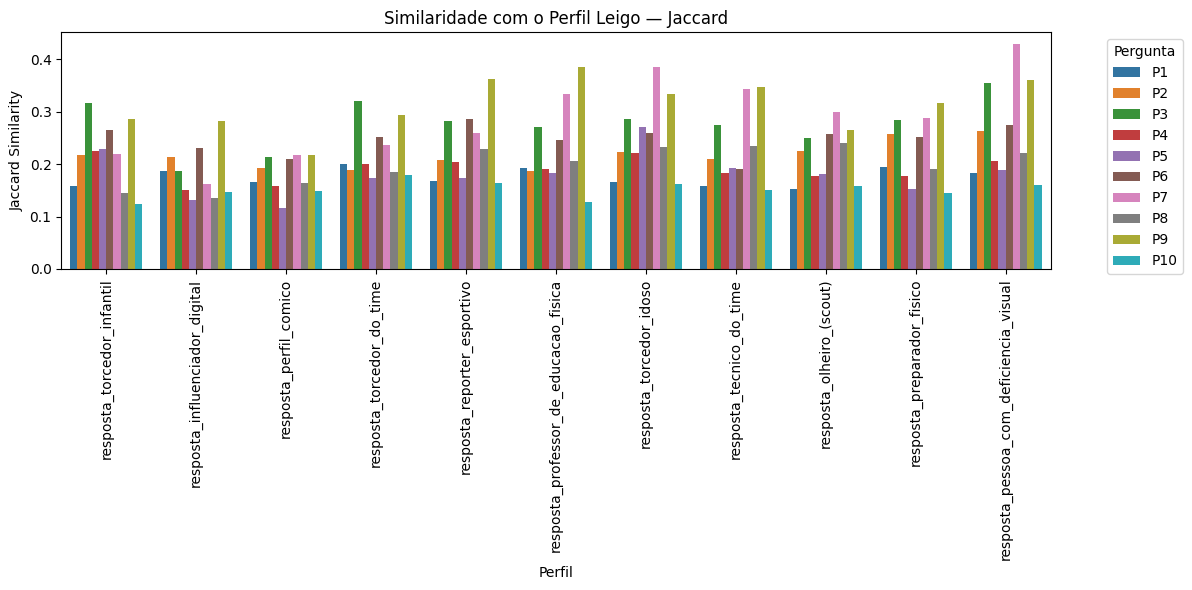

In [61]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados, x="perfil", y="jaccard", hue="pergunta_simplificada", dodge=True)
plt.title("Similaridade com o Perfil Leigo — Jaccard")
plt.xticks(rotation=90)
plt.ylabel("Jaccard Similarity")
plt.xlabel("Perfil")
plt.legend(title="Pergunta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

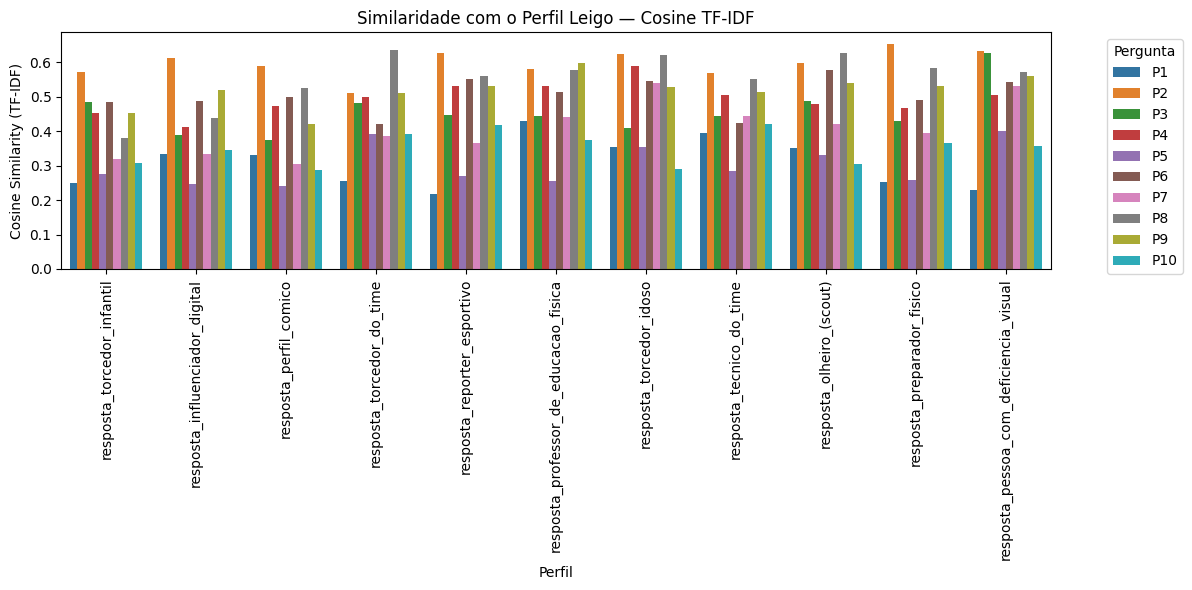

In [62]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados, x="perfil", y="cosine_tfidf", hue="pergunta_simplificada", dodge=True)
plt.title("Similaridade com o Perfil Leigo — Cosine TF-IDF")
plt.xticks(rotation=90)
plt.ylabel("Cosine Similarity (TF-IDF)")
plt.xlabel("Perfil")
plt.legend(title="Pergunta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

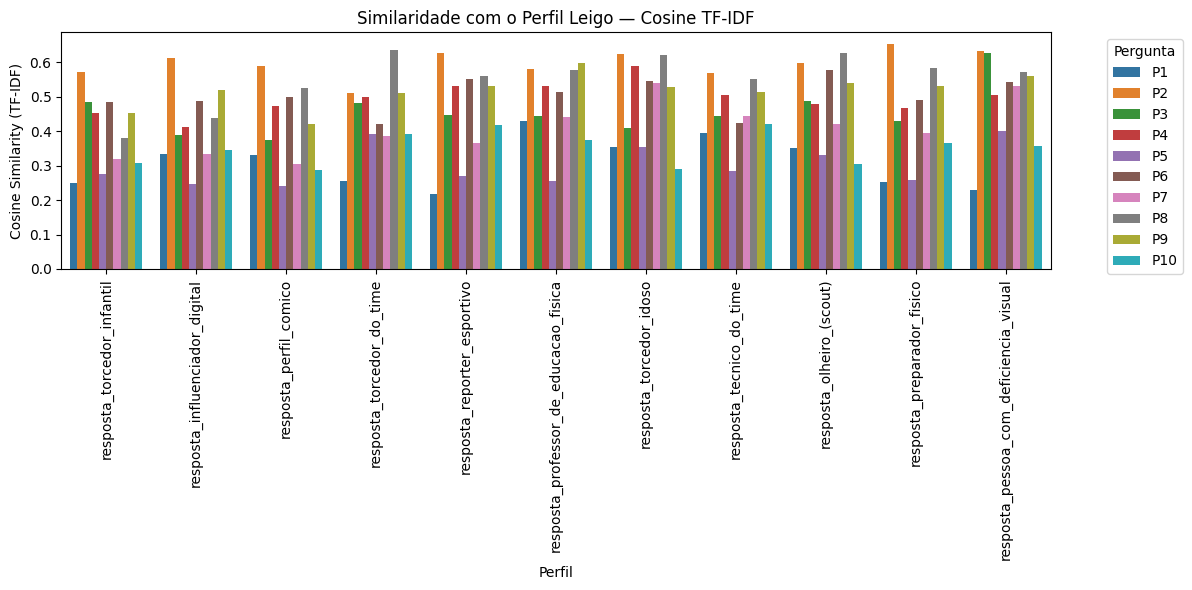

In [63]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados, x="perfil", y="cosine_tfidf", hue="pergunta_simplificada", dodge=True)
plt.title("Similaridade com o Perfil Leigo — Cosine TF-IDF")
plt.xticks(rotation=90)
plt.ylabel("Cosine Similarity (TF-IDF)")
plt.xlabel("Perfil")
plt.legend(title="Pergunta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

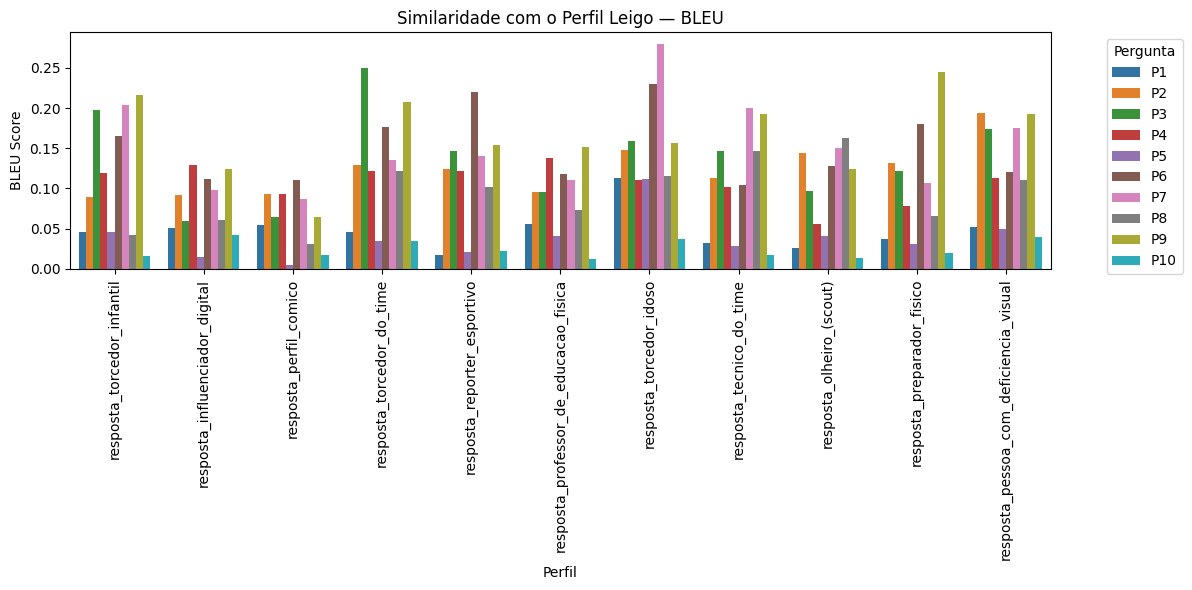

In [64]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados, x="perfil", y="bleu", hue="pergunta_simplificada", dodge=True)
plt.title("Similaridade com o Perfil Leigo — BLEU")
plt.xticks(rotation=90)
plt.ylabel("BLEU Score")
plt.xlabel("Perfil")
plt.legend(title="Pergunta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

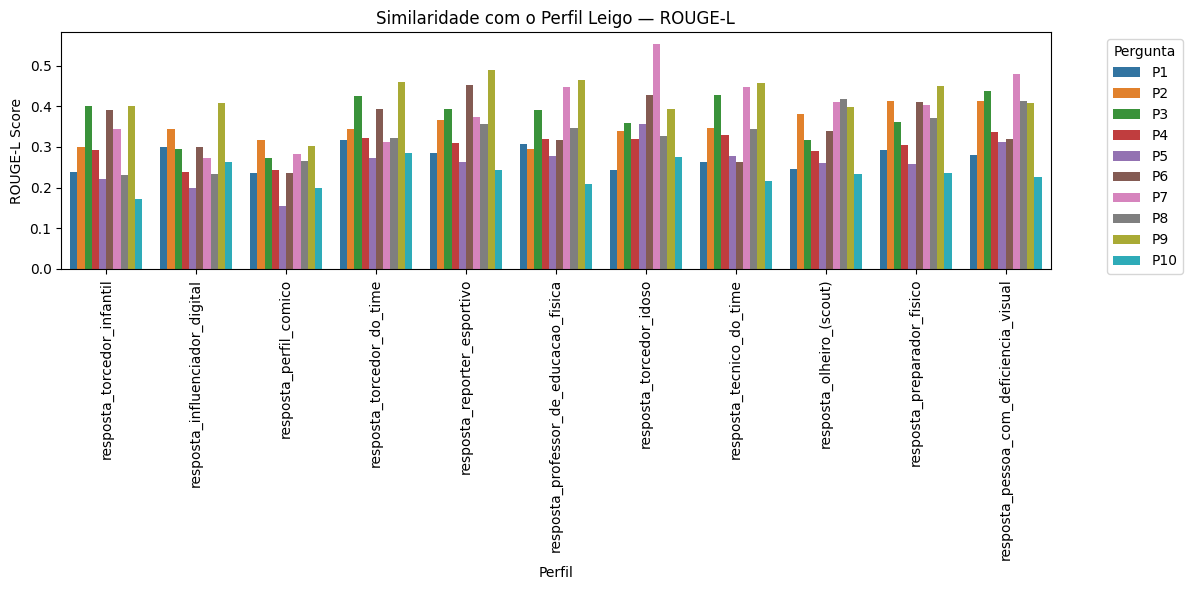

In [65]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados, x="perfil", y="rouge_l", hue="pergunta_simplificada", dodge=True)
plt.title("Similaridade com o Perfil Leigo — ROUGE-L")
plt.xticks(rotation=90)
plt.ylabel("ROUGE-L Score")
plt.xlabel("Perfil")
plt.legend(title="Pergunta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

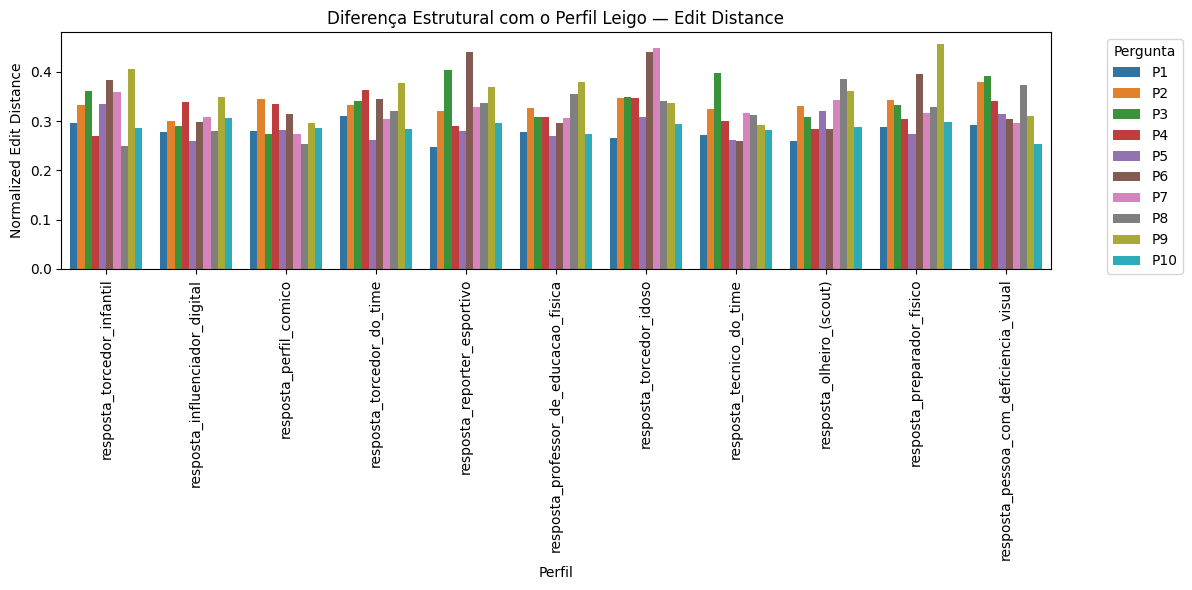

In [66]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados, x="perfil", y="edit_distance", hue="pergunta_simplificada", dodge=True)
plt.title("Diferença Estrutural com o Perfil Leigo — Edit Distance")
plt.xticks(rotation=90)
plt.ylabel("Normalized Edit Distance")
plt.xlabel("Perfil")
plt.legend(title="Pergunta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Comparação das Respostas Globalmente


Agora, vamos agrupar por perfil.

In [70]:
# Calcula média e desvio padrão das métricas por perfil
df_estatisticas = df_resultados.groupby("perfil")[["jaccard", "cosine_tfidf", "bleu", "rouge_l", "edit_distance"]].agg(['mean', 'std'])

# Organiza melhor os nomes das colunas
df_estatisticas.columns = ['_'.join(col) for col in df_estatisticas.columns]
df_estatisticas = df_estatisticas.reset_index()
df_estatisticas.head()

,perfil,jaccard_mean,jaccard_std,cosine_tfidf_mean,cosine_tfidf_std,bleu_mean,bleu_std,rouge_l_mean,rouge_l_std,edit_distance_mean,edit_distance_std
0,resposta_influenciador_digital,0.182697,0.048103,0.411970,0.106705,0.078333,0.038226,0.285037,0.059749,0.301251,0.027286
1,resposta_olheiro_(scout),0.220617,0.050471,0.471837,0.116055,0.094340,0.055573,0.328930,0.070375,0.316584,0.039184
2,resposta_perfil_comico,0.180661,0.034471,0.404694,0.115527,0.062224,0.035123,0.250607,0.048137,0.294091,0.029428
3,resposta_pessoa_com_deficiencia_visual,0.264334,0.090336,0.495354,0.128308,0.122051,0.060429,0.362649,0.079633,0.325783,0.044248
4,resposta_preparador_fisico,0.225955,0.061491,0.442522,0.130574,0.101658,0.070988,0.349829,0.072328,0.334149,0.054996


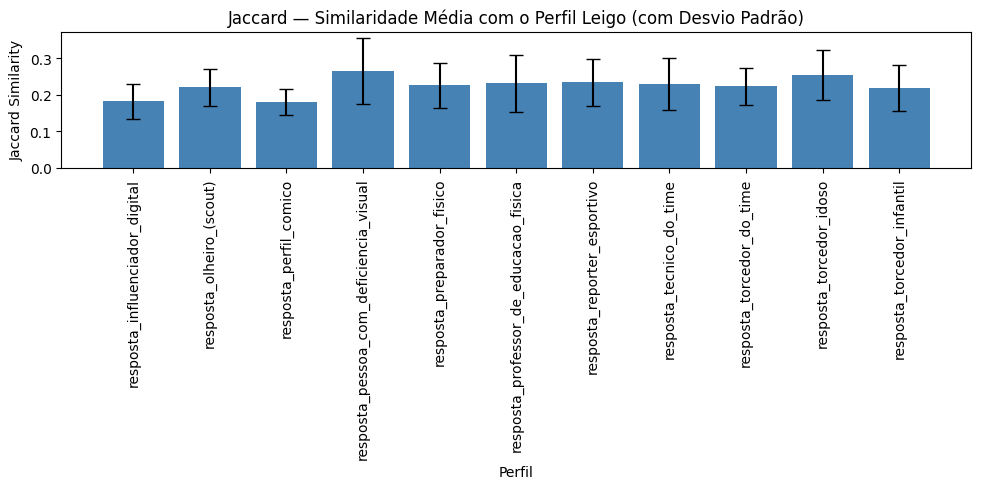

In [73]:
import numpy as np

# Dados
perfis = df_estatisticas["perfil"]
means = df_estatisticas["jaccard_mean"].values
stds = df_estatisticas["jaccard_std"].values

# Plot
plt.figure(figsize=(10, 5))
plt.bar(perfis, means, yerr=stds, capsize=5, color="steelblue")
plt.title("Jaccard — Similaridade Média com o Perfil Leigo (com Desvio Padrão)")
plt.ylabel("Jaccard Similarity")
plt.xlabel("Perfil")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


<span style="color:red">*Fazer o gráfico para as outras métricas*.</span>


## Clusterizando os resultados

In [74]:
# Agrupar por perfil e calcular média das métricas
df_avg = df_resultados.groupby("perfil")[["jaccard", "cosine_tfidf", "bleu", "rouge_l", "edit_distance"]].mean()
df_avg = df_avg.reset_index()

In [75]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar cada métrica para [0, 1] para evitar viés de escala
scaler = MinMaxScaler()
metricas_normalizadas = scaler.fit_transform(df_avg.drop(columns=["perfil"]))

df_metricas_norm = pd.DataFrame(metricas_normalizadas, columns=["jaccard", "cosine_tfidf", "bleu", "rouge_l", "edit_distance"])
df_metricas_norm["perfil"] = df_avg["perfil"]
df_metricas_norm.set_index("perfil", inplace=True)

In [76]:
from scipy.spatial.distance import pdist, squareform

# Cálculo da distância euclidiana entre vetores de perfis
dist_matrix = pdist(df_metricas_norm.values, metric="euclidean")
dist_df = pd.DataFrame(squareform(dist_matrix), index=df_metricas_norm.index, columns=df_metricas_norm.index)

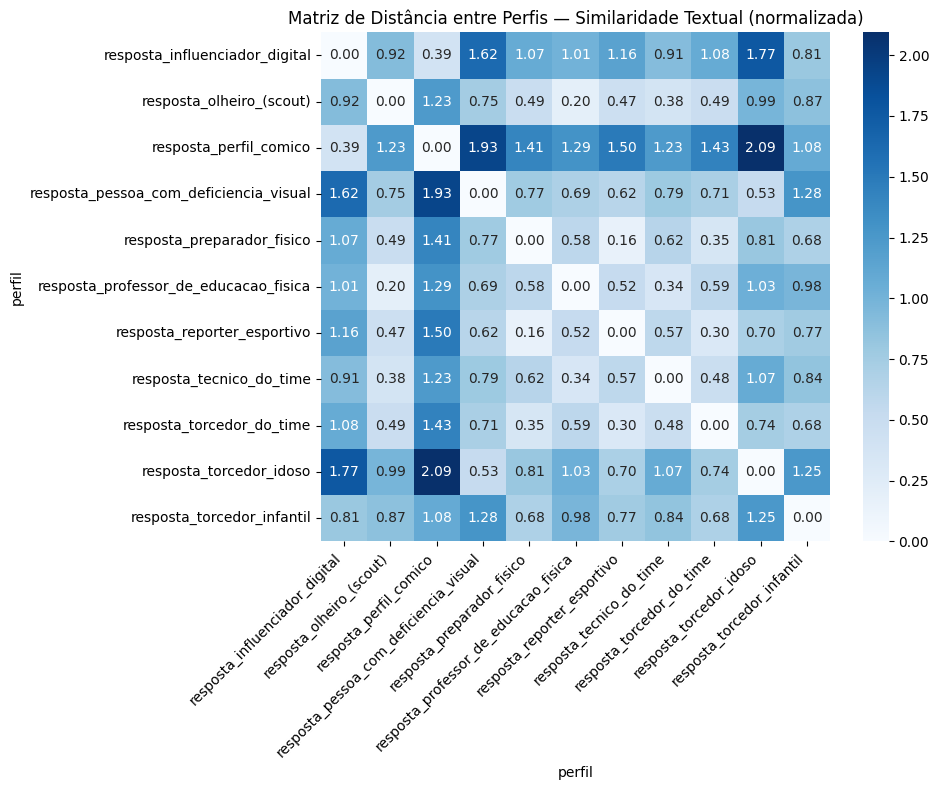

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(dist_df, cmap="Blues", annot=True, fmt=".2f", square=True)
plt.title("Matriz de Distância entre Perfis — Similaridade Textual (normalizada)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

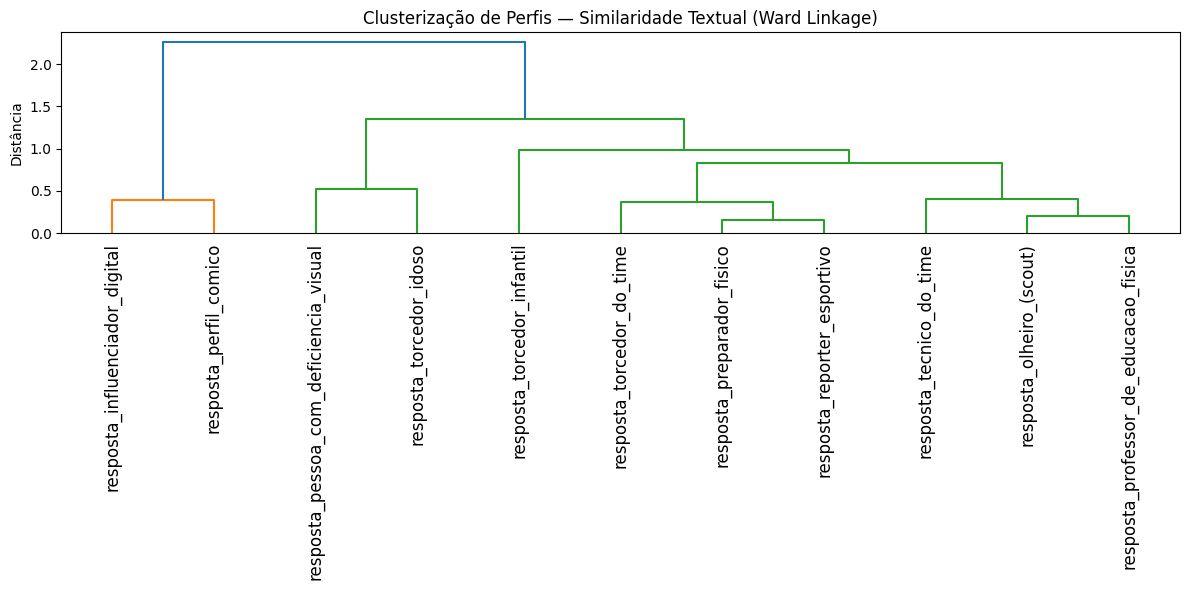

In [78]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Criar linkage matrix e gerar dendrograma
linkage_matrix = linkage(dist_matrix, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=df_metricas_norm.index.tolist(), leaf_rotation=90)
plt.title("Clusterização de Perfis — Similaridade Textual (Ward Linkage)")
plt.ylabel("Distância")
plt.tight_layout()
plt.show()

## Clusterizando os resultados com o KMeans

In [119]:
from sklearn.decomposition import PCA

# Remover a coluna de cluster anterior, se existir
X = df_metricas_norm.drop(columns=["cluster"], errors="ignore")

# Aplicar PCA para reduzir a 2 dimensões
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Criar um novo DataFrame com as componentes principais
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["perfil"] = df_metricas_norm.index  # preservar os perfis

In [123]:
from sklearn.cluster import KMeans

# Definir número de clusters (ex: 3) e fixar semente
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# Adicionar os rótulos dos clusters ao DataFrame
df_pca["cluster"] = clusters

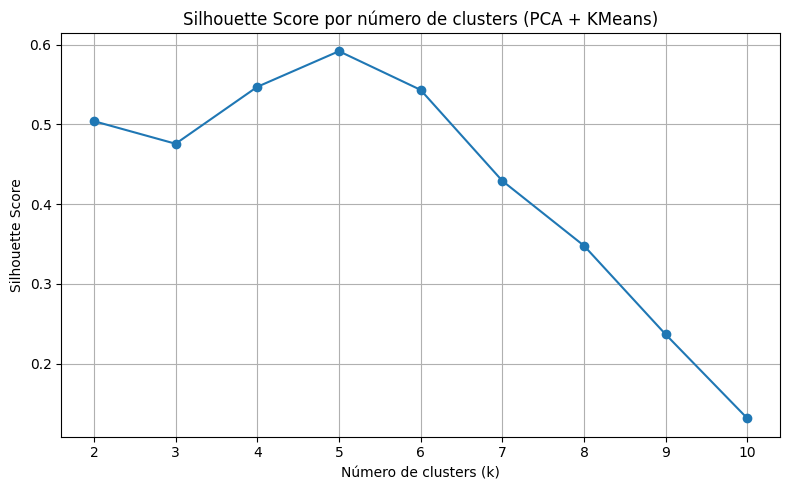

In [122]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 11)  # Testar de 2 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

# Visualizar os resultados
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Score por número de clusters (PCA + KMeans)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

In [126]:
silhouette_scores

[np.float64(0.5041859617529577),
 np.float64(0.4758326120843609),
 np.float64(0.5472358029139287),
 np.float64(0.5919178650587994),
 np.float64(0.5433700108146066),
 np.float64(0.42932086658165036),
 np.float64(0.3479838805741058),
 np.float64(0.23674849758789707),
 np.float64(0.13147464329464806)]

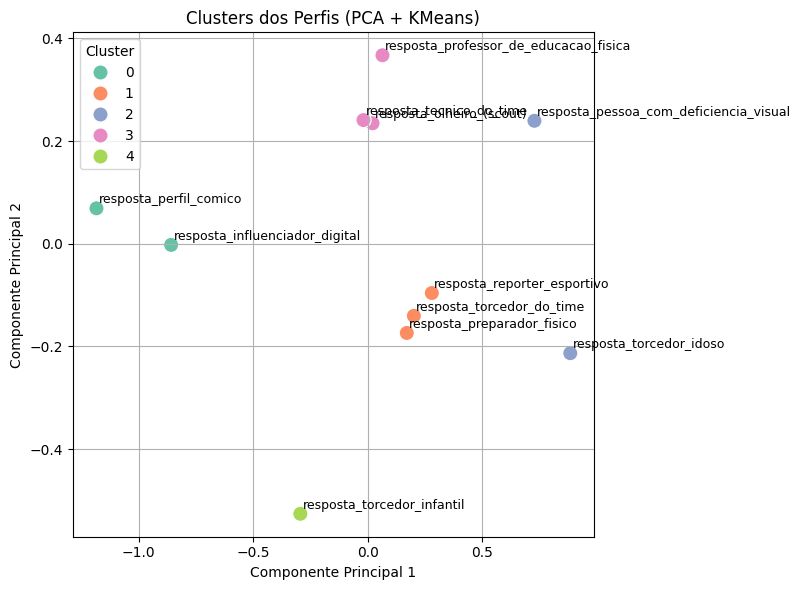

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1", y="PC2", hue="cluster", data=df_pca, palette="Set2", s=120
)

# Anotar os perfis nos pontos
for i in range(df_pca.shape[0]):
    plt.text(
        df_pca["PC1"][i] + 0.01,
        df_pca["PC2"][i] + 0.01,
        df_pca["perfil"][i],
        fontsize=9
    )

plt.title("Clusters dos Perfis (PCA + KMeans)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [125]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Número de clusters a ser testado (ex: 3)
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_metricas_norm["cluster"] = kmeans.fit_predict(df_metricas_norm)


# Considerar apenas os dados das métricas (sem o cluster)
X = df_metricas_norm.drop(columns="cluster").values
labels = df_metricas_norm["cluster"].values

sil_score = silhouette_score(X, labels, metric="euclidean")
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.2168


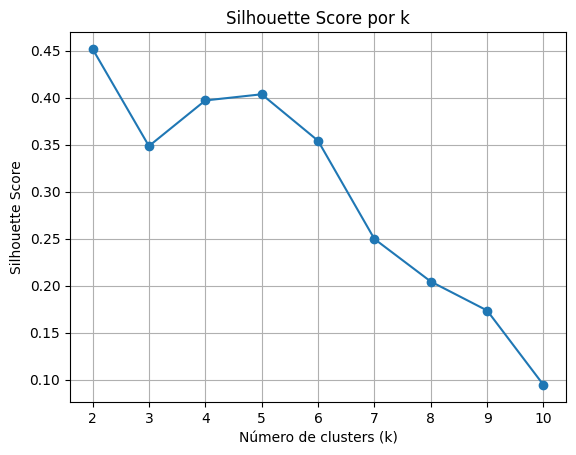

In [115]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

X = df_metricas_norm.drop(columns=["cluster"]).values
scores = []
ks = range(2, 11)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

plt.plot(ks, scores, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score por k")
plt.grid(True)
plt.show()

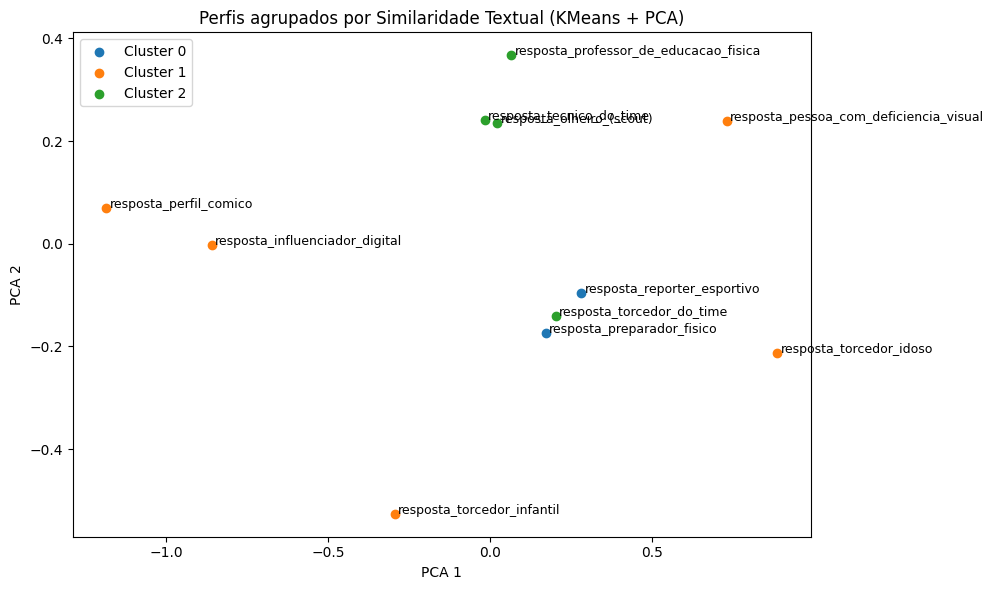

In [110]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduzir as dimensões para visualização
pca = PCA(n_components=2)
reduced = pca.fit_transform(df_metricas_norm.drop(columns="cluster"))

plt.figure(figsize=(10, 6))
for cluster_id in sorted(df_metricas_norm["cluster"].unique()):
    idx = df_metricas_norm["cluster"] == cluster_id
    plt.scatter(reduced[idx, 0], reduced[idx, 1], label=f"Cluster {cluster_id}")

# Adicionar nomes dos perfis
for i, perfil in enumerate(df_metricas_norm.index):
    plt.text(reduced[i, 0]+0.01, reduced[i, 1], perfil, fontsize=9)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Perfis agrupados por Similaridade Textual (KMeans + PCA)")
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
# Visualizar os perfis agrupados por cluster
for cluster_id in sorted(df_metricas_norm["cluster"].unique()):
    membros = df_metricas_norm[df_metricas_norm["cluster"] == cluster_id].index.tolist()
    print(f"Cluster {cluster_id}: {membros}")

Cluster 0: ['resposta_olheiro_(scout)', 'resposta_preparador_fisico', 'resposta_professor_de_educacao_fisica', 'resposta_reporter_esportivo', 'resposta_tecnico_do_time', 'resposta_torcedor_do_time']
Cluster 1: ['resposta_influenciador_digital', 'resposta_perfil_comico']
Cluster 2: ['resposta_pessoa_com_deficiencia_visual', 'resposta_torcedor_idoso']
Cluster 3: ['resposta_torcedor_infantil']


In [85]:
from sklearn.metrics import pairwise_distances
import numpy as np

# Matriz de distância (pode ser usada para calcular dissimilaridade entre perfis)
distance_matrix = pairwise_distances(
    df_metricas_norm.drop(columns="cluster"),
    metric="euclidean"
)

# Criar dataframe nomeado
df_dist_matrix = pd.DataFrame(
    distance_matrix,
    index=df_metricas_norm.index,
    columns=df_metricas_norm.index
)

In [86]:
from collections import defaultdict

cluster_ids = df_metricas_norm["cluster"]
cluster_members = defaultdict(list)

# Agrupar perfis por cluster
for perfil, cluster in cluster_ids.items():
    cluster_members[cluster].append(perfil)

# Calcular distâncias intra e inter-cluster
intra_cluster_dists = []
inter_cluster_dists = []

for i in df_dist_matrix.index:
    for j in df_dist_matrix.columns:
        if i == j:
            continue
        dist = df_dist_matrix.loc[i, j]
        if cluster_ids[i] == cluster_ids[j]:
            intra_cluster_dists.append(dist)
        else:
            inter_cluster_dists.append(dist)

media_intra = np.mean(intra_cluster_dists)
media_inter = np.mean(inter_cluster_dists)

print(f"Média das distâncias intra-cluster: {media_intra:.4f}")
print(f"Média das distâncias inter-cluster: {media_inter:.4f}")

Média das distâncias intra-cluster: 0.4392
Média das distâncias inter-cluster: 1.0678


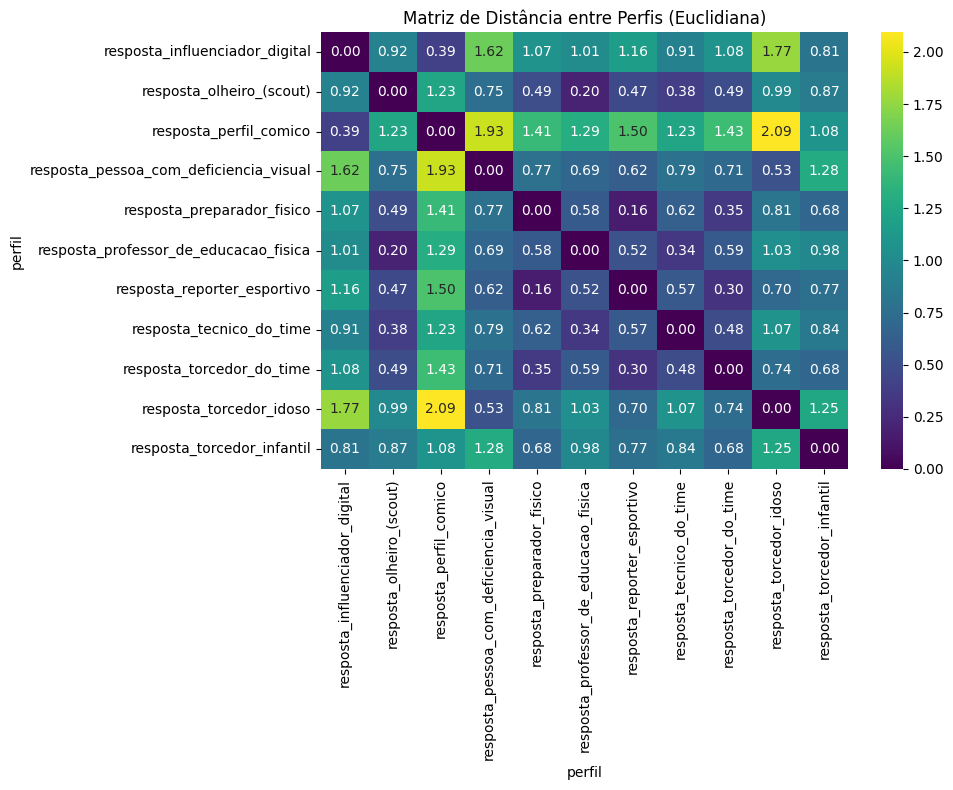

In [87]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(df_dist_matrix, cmap="viridis", annot=True, fmt=".2f")
plt.title("Matriz de Distância entre Perfis (Euclidiana)")
plt.tight_layout()
plt.show()

In [90]:
from sklearn.metrics import silhouette_score

# Considerar apenas os dados das métricas (sem o cluster)
X = df_metricas_norm.drop(columns="cluster").values
labels = df_metricas_norm["cluster"].values

sil_score = silhouette_score(X, labels, metric="euclidean")
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.3166


# Similaridade Semântica

## Similaridade dentro de uma mesma pergunta

In [127]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
import pandas as pd
import numpy as np
from tqdm import tqdm

In [128]:
model = SentenceTransformer("all-MiniLM-L6-v2")  # Rápido e eficiente

In [129]:
perfis = [col for col in df.columns if col != "pergunta"]

resultados_semanticos = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    pergunta = row["pergunta"]
    respostas = [row[perfil] for perfil in perfis]

    # Obter embeddings
    embeddings = model.encode(respostas)

    # Calcular similaridade para cada par
    for (i, j) in combinations(range(len(perfis)), 2):
        sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
        resultados_semanticos.append({
            "pergunta": pergunta,
            "perfil1": perfis[i],
            "perfil2": perfis[j],
            "similaridade_semantica": sim
        })

df_semantica_pergunta = pd.DataFrame(resultados_semanticos)

100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


In [135]:
df_semantica_pergunta

,pergunta,perfil1,perfil2,similaridade_semantica
0,Quais jogadores mais se destacaram no jogo con...,resposta_torcedor_infantil,resposta_influenciador_digital,0.724879
1,Quais jogadores mais se destacaram no jogo con...,resposta_torcedor_infantil,resposta_perfil_comico,0.812612
2,Quais jogadores mais se destacaram no jogo con...,resposta_torcedor_infantil,resposta_torcedor_do_time,0.726972
3,Quais jogadores mais se destacaram no jogo con...,resposta_torcedor_infantil,resposta_reporter_esportivo,0.750586
4,Quais jogadores mais se destacaram no jogo con...,resposta_torcedor_infantil,resposta_professor_de_educacao_fisica,0.685122
...,...,...,...,...
655,O time apresentou sinais de desgaste físico du...,resposta_olheiro_(scout),resposta_pessoa_com_deficiencia_visual,0.647156
656,O time apresentou sinais de desgaste físico du...,resposta_olheiro_(scout),resposta_leigo,0.601777
657,O time apresentou sinais de desgaste físico du...,resposta_preparador_fisico,resposta_pessoa_com_deficiencia_visual,0.828030
658,O time apresentou sinais de desgaste físico du...,resposta_preparador_fisico,resposta_leigo,0.648226


/var/folders/57/zxs7x8nd6g38q929k2lys2n80000gn/T/ipykernel_97621/4050009924.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


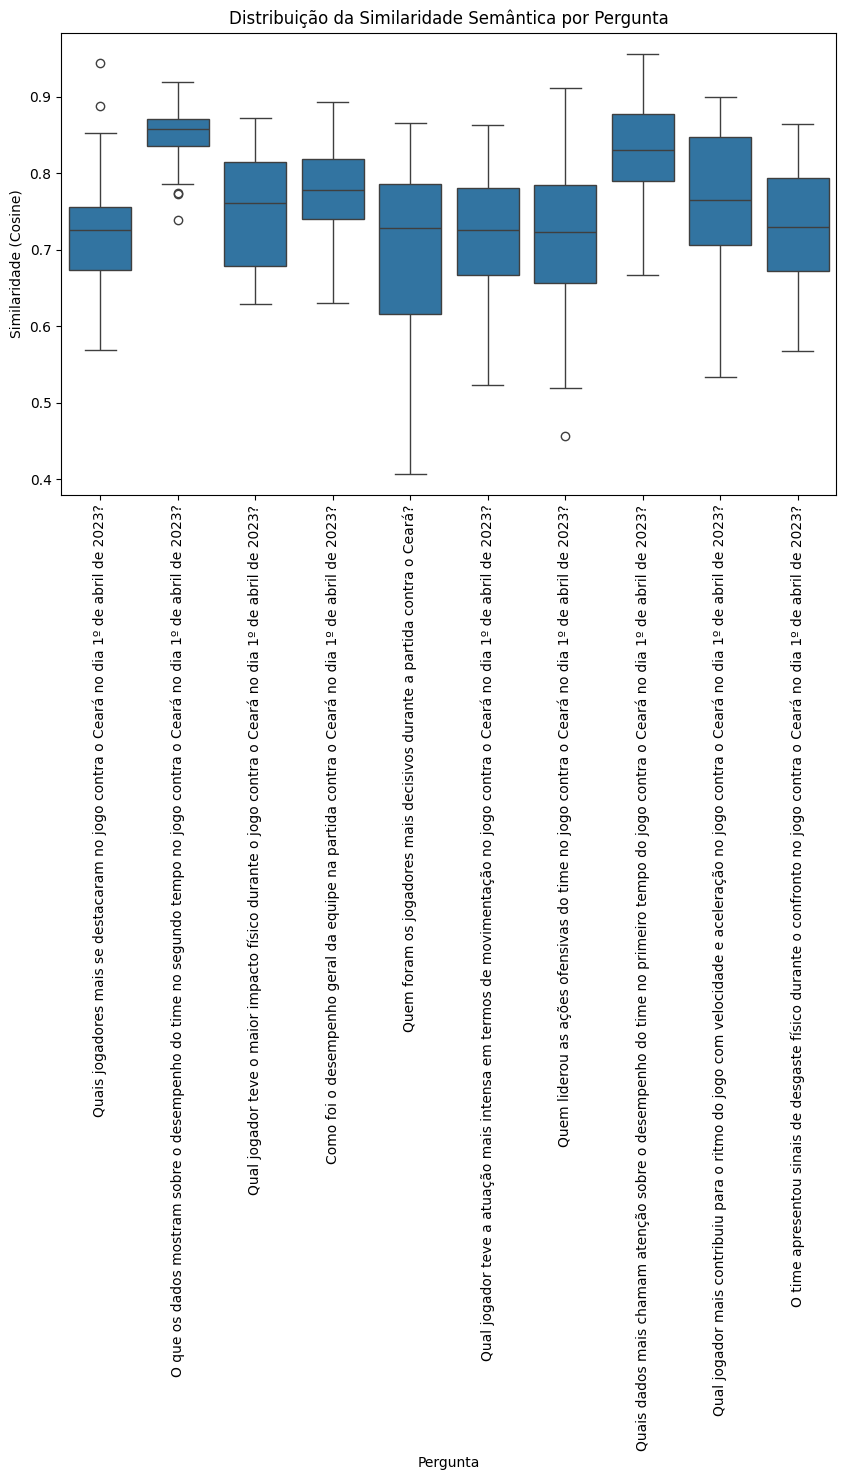

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_semantica_pergunta, x="pergunta", y="similaridade_semantica")
plt.xticks(rotation=90)
plt.title("Distribuição da Similaridade Semântica por Pergunta")
plt.ylabel("Similaridade (Cosine)")
plt.xlabel("Pergunta")
plt.tight_layout()
plt.show()

## Similaridade semântica entre perfis (globalmente)

In [131]:
respostas_concatenadas = {}

for perfil in perfis:
    respostas_concatenadas[perfil] = " ".join(df[perfil].astype(str).tolist())

In [132]:
respostas_concatenadas

{'resposta_torcedor_infantil': 'Oi, pequeno torcedor! Vamos falar sobre o jogão contra o Ceará que aconteceu no dia 1º de abril de 2023! Os jogadores que brilharam em campo foram muitos, e aqui estão alguns dos que se destacaram:\\n\\n1. **Tomas Pochettino**: Ele foi super rápido, com uma média de velocidade de 1.94!\\n2. **Juan Martin Lucero**: Outro craque! Ele acelerou bem, com uma média de 1.45!\\n3. **Lucas Sasha**: Ele também se destacou, correndo a uma média de 1.39!\\n4. **Bruno Pacheco**: Um grande jogador, com velocidade média de 1.36!\\n5. **Yago Pikachu**: Que nome legal! Ele chegou a 1.20 de média!\\n6. **Tinga**: Com uma média de 1.17, ele não ficou atrás!\\n7. **Calebe**: Ele também é rápido, com média de 1.17 igual ao Tinga!\\n\\nOs jogadores mostraram muito talento e divertiram a galera! Que tal acompanhar os próximos jogos e torcer por eles? Vamos juntos nessa! 💚⚽️ Oi, pequeno torcedor! Vamos falar sobre como nosso time se saiu no segundo tempo contra o Ceará no dia 1

In [133]:
embeddings_perfil = {
    perfil: model.encode([texto])[0]
    for perfil, texto in respostas_concatenadas.items()
}

similaridades_globais = []

for perfil1, perfil2 in combinations(perfis, 2):
    emb1 = embeddings_perfil[perfil1]
    emb2 = embeddings_perfil[perfil2]
    sim = cosine_similarity([emb1], [emb2])[0][0]
    similaridades_globais.append({
        "perfil1": perfil1,
        "perfil2": perfil2,
        "similaridade_global": sim
    })

df_semantica_global = pd.DataFrame(similaridades_globais)

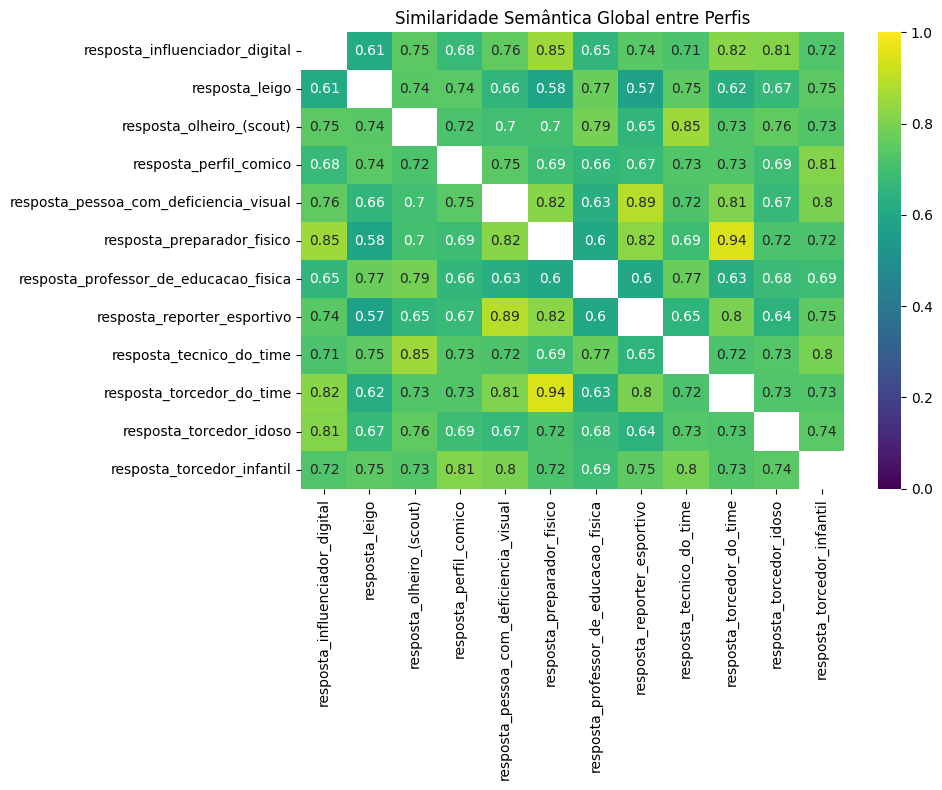

In [134]:
# Criar matriz para heatmap
matriz = pd.pivot_table(df_semantica_global,
                        index="perfil1",
                        columns="perfil2",
                        values="similaridade_global")

# Tornar matriz simétrica
matriz = matriz.combine_first(matriz.T)

plt.figure(figsize=(10, 8))
sns.heatmap(matriz, annot=True, cmap="viridis", vmin=0, vmax=1)
plt.title("Similaridade Semântica Global entre Perfis")
plt.tight_layout()
plt.show()